# Deep Learning Final Project

For the final project I picked a dataset from Kaggle that includes 5,856 images from chest x-rays that can be used to help determine if a patient has pneumonia or not.  There are 4,192 training observations, 1,040 validation observations, and 624 testing observations in the dataset.  This task is critical application of deep learning as it can help healthcare professionals identify pneumonia in patients.  

https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images/data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
!pip install keras_tuner
import keras_tuner as kt

In [ ]:
#Import Data
from google.colab import files
files.upload()

In [4]:
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

Dataset URL: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.14G/1.14G [01:02<00:00, 22.0MB/s]
100% 1.14G/1.14G [01:02<00:00, 19.7MB/s]


In [7]:
# Extract the dataset
with zipfile.ZipFile("pneumonia-xray-images.zip", 'r') as zip_ref:
    zip_ref.extractall("path/to/dataset")

In [8]:
# Define paths to each set
train_dir = 'path/to/dataset/train'
val_dir = 'path/to/dataset/val'
test_dir = 'path/to/dataset/test'

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False
)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Exploratory Data Analysis

First, let's take a look at some sample images to get a sense of the content and nature of the X-rays.

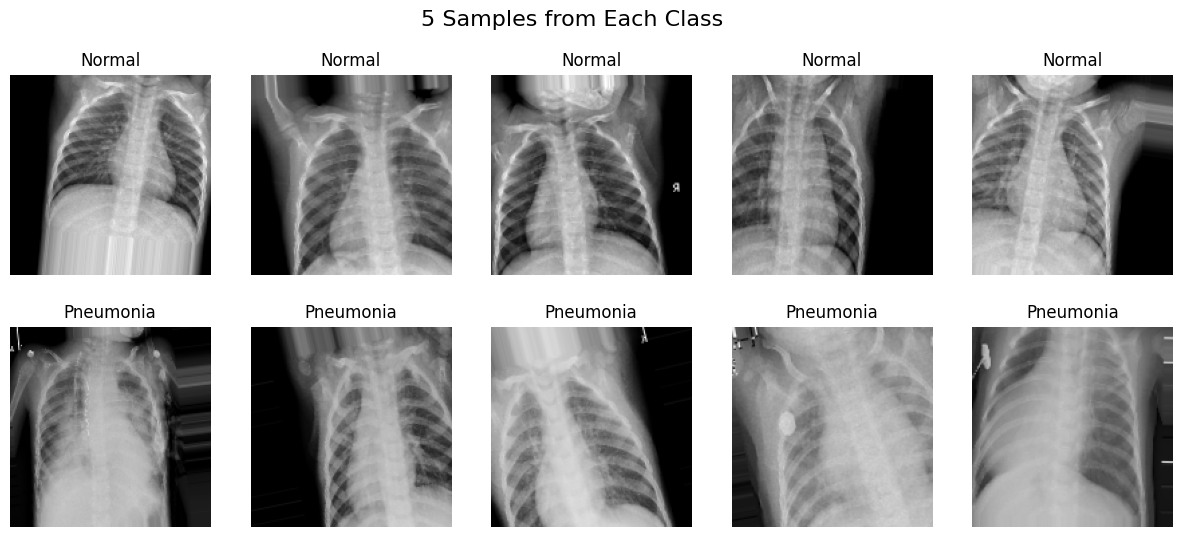

In [9]:
# Define function to display samples
def display_samples(generator, class_labels, samples_per_class=5):
    images_shown = {label: 0 for label in class_labels}
    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 6))
    fig.suptitle("5 Samples from Each Class", fontsize=16)

    for images, labels in generator:
        for img, label in zip(images, labels):
            class_label = class_labels[int(label)]
            if images_shown[class_label] < samples_per_class:
                ax = axes[int(label), images_shown[class_label]]
                ax.imshow(img)
                ax.set_title(class_label)
                ax.axis('off')
                images_shown[class_label] += 1

            if all(count >= samples_per_class for count in images_shown.values()):
                break
        if all(count >= samples_per_class for count in images_shown.values()):
            break
    plt.show()

class_labels = ['Normal', 'Pneumonia']
display_samples(train_generator, class_labels)

Next, I want to check the balance between the classes - normal vs. pneumonia images.

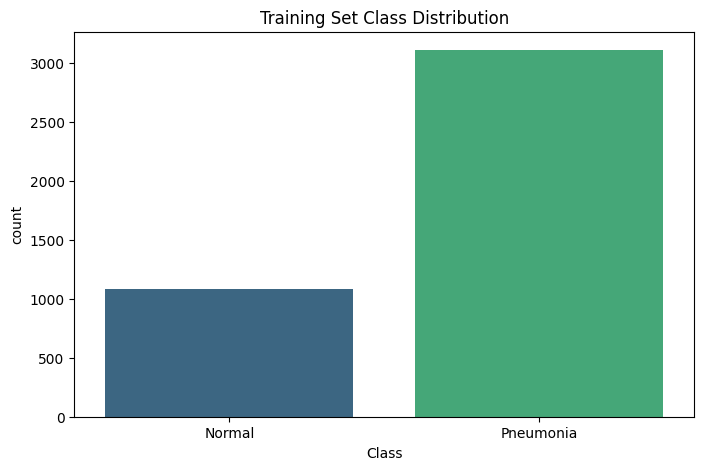

In [10]:
train_labels = [class_labels[label] for label in train_generator.classes]
train_df = pd.DataFrame({'Class': train_labels})

plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Class', hue='Class', palette='viridis', dodge=False)
plt.legend([], [], frameon=False)
plt.title('Training Set Class Distribution')
plt.show()

The classes have a significant imbalance with many more pneumonia samples than normal samples, this makes sense as an image likely wouldn't be taken unless there was reason to be believe a patient might have pneumonia.  This will have to be account for in the final model training.  

# Model Architecture

This CNN model architecture, consisting of multiple convolutional and pooling layers, is well-suited for pneumonia detection as it effectively captures spatial hierarchies and patterns within X-ray images, crucial for distinguishing subtle differences between normal and pneumonia cases. The inclusion of batch normalization and dropout layers helps improve generalization and prevent overfitting, making the model more reliable for medical image classification.

In order to try and accurately predict pneumonia cases, I will look at accuracy, recall, and the f1_score but since the the model can only optimize for one parameter, I will be focus on recall.  Recall will be critical because you want to maximize the true positive pneumonia cases so patients can be treated.




In [11]:
def f1_score_metric(y_true, y_pred):
    precision = Precision()(y_true, y_pred)
    recall = Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [12]:
def build_model(hp):
    model = Sequential()

    # Define the model architecture
    model.add(tf.keras.layers.Input(shape=(150, 150, 3)))
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('filters_2', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with precision and recall metrics
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    return model


# Hyperparameter Tuning

Hyperparameter tuning will be set up using the Keras tuner with Bayesian Optimization and an objective to maximize validation recall.  Bayesian optimization will help minimize the number of trials and narrow down the best parameters. I'll also limit it to 5 trials because it will take a while to run.  I will look at variations in number of filters in convolution layers, dense layer units, and learning rate.

In [13]:
# Set up Keras Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_recall',
    max_trials=5,
    directory='my_dir',
    project_name='pneumonia_classification',
    overwrite=True
)

Early stopping and checkpoints are used to ensure efficient training by stopping training if the objective stops improving, this can help reduce overfitting as well.  The check point will ensure the best parameters are saved.

In [14]:
# Early stopping and checkpoint callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5)


In [15]:
# Run the hyperparameter search
tuner.search(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stop, checkpoint])

Trial 5 Complete [00h 18m 55s]
val_recall: 1.0

Best val_recall So Far: 1.0
Total elapsed time: 01h 31m 38s


In [25]:
# Get the best model and retrain it on the full data
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 74s 501ms/step - accuracy: 0.8007 - loss: 1.5428 - precision: 0.8482 - recall: 0.8900 - val_accuracy: 0.7433 - val_loss: 5.5458 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 492ms/step - accuracy: 0.7843 - loss: 1.7911 - precision: 0.8244 - recall: 0.9045 - val_accuracy: 0.7500 - val_loss: 1.1728 - val_precision: 0.7493 - val_recall: 0.9974
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 503ms/step - accuracy: 0.8042 - loss: 0.6977 - precision: 0.8319 - recall: 0.9254 - val_accuracy: 0.5567 - val_loss: 0.6706 - val_precision: 0.9727 - val_recall: 0.4153
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 493ms/step - accuracy: 0.7988 - loss: 0.7969 - precision: 0.8210 - recall: 0.9358 - val_accuracy: 0.8808 - val_loss: 0.5020 - val_precision: 0.9488 - val_recall: 0.8875
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 499ms/step - accuracy: 0.7941 - loss: 0.7272 - precision: 0.8121 - recall: 0.9394 - val_accuracy: 0.8750

# Results and Analysis

The first results showed very high recall for the pneumonia class but very low recall for the normal class.  I tried a few iterations of changes the class balance in training the model to account for the heavy skew toward pneumonia cases but it didn't help the results.  I also chaged the threshold for an image to be classified as pneumonia and was although there was some loss in recall from the pneumonia class, there was significant improvement in recall of the normal class.

In [29]:
# Predict on the test set
y_true = test_generator.classes
y_pred = (best_model.predict(test_generator) > 0.5).astype("int32")

# Classification report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step
              precision    recall  f1-score   support

      Normal       0.96      0.23      0.37       234
   Pneumonia       0.68      0.99      0.81       390

    accuracy                           0.71       624
   macro avg       0.82      0.61      0.59       624
weighted avg       0.79      0.71      0.65       624

Confusion Matrix:
[[ 54 180]
 [  2 388]]


In [28]:
# Predict on the test set
y_true = test_generator.classes
y_pred = (best_model.predict(test_generator) > 0.6).astype("int32")

# Classification report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step
              precision    recall  f1-score   support

      Normal       0.82      0.59      0.68       234
   Pneumonia       0.79      0.92      0.85       390

    accuracy                           0.80       624
   macro avg       0.80      0.76      0.77       624
weighted avg       0.80      0.80      0.79       624

Confusion Matrix:
[[138  96]
 [ 31 359]]


In [30]:
# Predict on the test set
y_true = test_generator.classes
y_pred = (best_model.predict(test_generator) > 0.7).astype("int32")

# Classification report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step
              precision    recall  f1-score   support

      Normal       0.75      0.74      0.75       234
   Pneumonia       0.85      0.85      0.85       390

    accuracy                           0.81       624
   macro avg       0.80      0.80      0.80       624
weighted avg       0.81      0.81      0.81       624

Confusion Matrix:
[[174  60]
 [ 59 331]]


Changing the threshold to 0.7 appears to give the best balance for recall in both classes as well as the highest f1 scores.

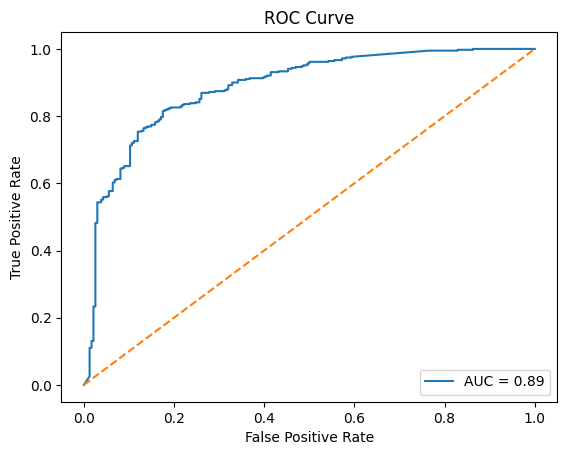

In [33]:
from sklearn.metrics import roc_curve, auc

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line (random guessing)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The ROC curve demonstrates the model’s ability to distinguish between pneumonia and normal cases, with an AUC score of 0.89 indicating high overall performance. This score suggests that the model is effective at identifying pneumonia cases, balancing the trade-off between true positive and false positive rates across various thresholds.

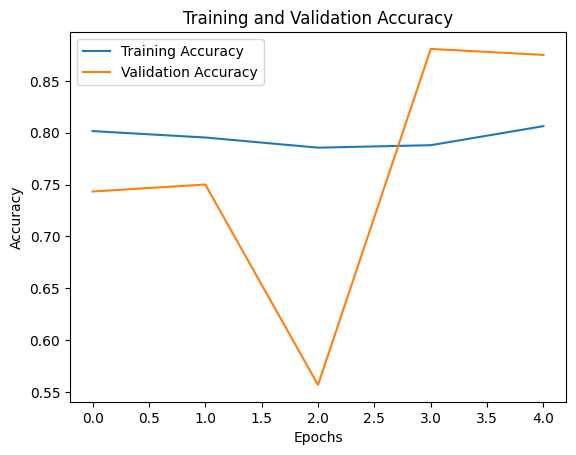

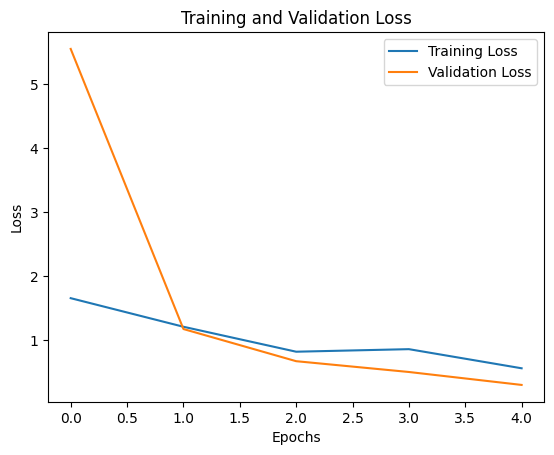

In [34]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

The Training and Validation Accuracy plot shows that while training accuracy remains stable, validation accuracy experiences fluctuations across epochs, indicating potential issues with model generalization or variability in validation performance.

The Training and Validation Loss plot reveals a steady decline in both training and validation loss, suggesting that the model is learning effectively. However, the large initial drop in validation loss may indicate early overfitting, which warrants monitoring in further training.

# Conclusions

The threshold of 0.7 achieved the best f1 score and balanced recall for both classes.  This would have to be reviewed with a domain expert to help determine what is most important in the results, if it is ok to sacrifice some true positives to avoid potentially significant false positives.

While the model performed fairly well, one of the main challenges was the large class imbalance.  In future iterations I might try using different techniques to adjust for this such as SMOTE which would create synthetic normal images to increase the normal samples size.  

In addition to addressing class imbalance through techniques like SMOTE, I could explore focal loss as an alternative to binary cross-entropy, which would place more emphasis on harder-to-classify samples and potentially improve recall for the minority class. Another area for improvement could be model architecture—experimenting with transfer learning from medical-specific pre-trained models could enhance feature extraction tailored to X-ray images. Finally, implementing ensemble learning with multiple models could combine their strengths and provide more robust predictions, further improving the balance between sensitivity and specificity for clinical applicability.